TODO Data normalization

TODO Data augmentation

TODO Global pooling

TODO New schema to train model (def train model)

TODO Reorganizate first cell (Split tasks)

Hyperparameters
Read data
Transform datasets
Build train, validation and test datasets
Build dataloaders

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from utilsMAP import *

#
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001 # optimizer
weight_decay = 1e-4 # optimizer

# Define transformation to data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Read train and test dataset. Apply transform
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Build validation dataset
train_size = int(0.85 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Build dataloaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Imprimir tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(trainset)}")
print(f"Tamaño del conjunto de validación: {len(valset)}")
print(f"Tamaño del conjunto de test: {len(testset)}")


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 42500
Tamaño del conjunto de validación: 7500
Tamaño del conjunto de test: 10000


Build neuronal network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Definimos las capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # Definimos las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # nn.MaxPool2d(kernel_size, stride=None, ...)

        # Definimos las capas fully connected (clasificador)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

        # Definimos la función de activación
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4) # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()

# Contamos el número total de parámetros del modelo
total_params = sum(p.numel() for p in model.parameters())
print(f'Número total de parámetros: {total_params:,}')

# Desglose de parámetros por capa
print('\nDesglose de parámetros por capa:')
for name, param in model.named_parameters():
    print(f'{name}: {param.numel():,} parámetros')

Número total de parámetros: 122,570

Desglose de parámetros por capa:
conv1.weight: 864 parámetros
conv1.bias: 32 parámetros
conv2.weight: 18,432 parámetros
conv2.bias: 64 parámetros
conv3.weight: 36,864 parámetros
conv3.bias: 64 parámetros
fc1.weight: 65,536 parámetros
fc1.bias: 64 parámetros
fc2.weight: 640 parámetros
fc2.bias: 10 parámetros


Run train

Epoch 1, Loss: 1.6739817366564185, Acc: 38.548235294117646, Val Loss: 1.506987381789644, Val Acc: 45.45333333333333
Epoch 2, Loss: 1.334960739415391, Acc: 51.781176470588235, Val Loss: 1.2432713089352947, Val Acc: 55.52
Epoch 3, Loss: 1.1830482711469321, Acc: 57.56941176470588, Val Loss: 1.1522274431535753, Val Acc: 58.986666666666665
Epoch 4, Loss: 1.067240382047524, Acc: 62.07529411764706, Val Loss: 1.0330760731535442, Val Acc: 63.38666666666666
Epoch 5, Loss: 0.9818633740109609, Acc: 65.23058823529412, Val Loss: 0.963153469865605, Val Acc: 65.84
Epoch 6, Loss: 0.9097934450422015, Acc: 67.79058823529412, Val Loss: 0.9945783251422947, Val Acc: 65.61333333333333
Epoch 7, Loss: 0.8491461524389741, Acc: 70.33176470588235, Val Loss: 0.9491274276022184, Val Acc: 66.4
Epoch 8, Loss: 0.8008082460191913, Acc: 71.84, Val Loss: 0.8891207515183142, Val Acc: 68.89333333333333
Epoch 9, Loss: 0.7603682149173622, Acc: 73.30588235294118, Val Loss: 0.9305881837667045, Val Acc: 67.68
Epoch 10, Loss: 0.

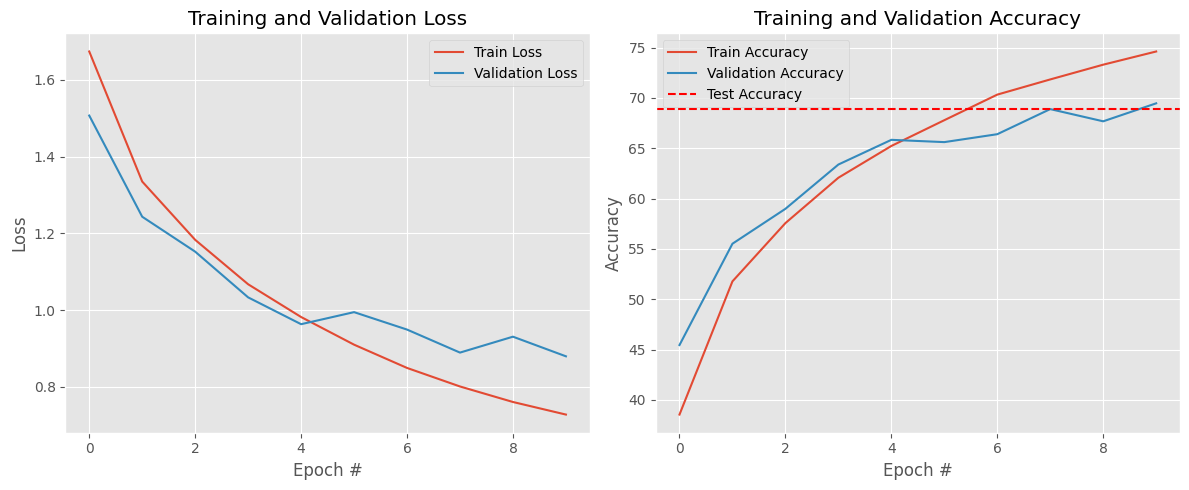

In [ ]:
# Instance model
model = ConvNet()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# TODO Include in train_epoch
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    loss, acc = train_epoch(model, device, trainloader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, device, valloader, criterion)
    train_losses.append(loss)
    train_accs.append(acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}, Loss: {loss}, Acc: {acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

# Test model
accuracy = evaluate_model(model, testloader, device)
print('Test accuracy: %.3f' % accuracy)

plot_training_curves(train_losses, val_losses, train_accs, val_accs, num_epochs, test_acc=accuracy)